In [1]:
%load_ext watermark
%watermark -v -p torch,numpy

CPython 3.5.2
IPython 5.1.0

torch n
numpy 1.11.3


In [2]:
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [10]:
# target dist. params
data_mean = 4
data_stddev = 1.25

# Discriminator params
d_input_size = 100   # Minibatch size - cardinality of distributions
d_hidden_size = 50   # Discriminator hidden unit
d_output_size = 1    # Single dimension for 'real' vs. 'fake'

# Generator params
g_input_size = 100     # Random noise dimension coming into generator, per output vector
g_hidden_size = 50   # Generator hidden unit
g_output_size = 100    # generate a value at a time

num_epochs = 5000

# 'k' steps in the original GAN paper. 
# Can put the discriminator on higher training freq than generator
d_steps = 5
g_steps = 5

In [11]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.map1(x))
        x = F.relu(self.map2(x))
        return F.sigmoid(self.map3(x))

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.map1(x))
        x = F.relu(self.map2(x))
        return self.map3(x)

# get gaussian dist.
real_sampler = lambda n: torch.Tensor(1, n).normal_(data_mean, data_stddev)
# get normal dist.
fake_sampler = lambda n: torch.rand(1, n)

In [12]:
# D's input_size = sampling + noise
D = Discriminator(input_size=d_input_size, hidden_size=d_hidden_size, output_size=d_output_size)
G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)

loss = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
d_optimizer = optim.Adam(D.parameters())
g_optimizer = optim.Adam(G.parameters())

# for stat display
d_real_error = []
d_fake_error = []
g_fake_error = []
fake_means = []
fake_stds = []

for epoch in range(num_epochs):
    
    # Training D with gaussian dist. and G's fake data.
    for d_index in range(d_steps):
        # clear D's gradient
        D.zero_grad()
        
        # train D with gaussian dist.
        real_data = Variable(real_sampler(d_input_size)) # dim(1, d_input_size)
        real_decision = D(real_data)
        real_error = loss(real_decision, Variable(torch.ones(1)))  # it's true(torch.ones)
        d_real_error.append(real_error.data.numpy()[0])
        real_error.backward() # compute/store gradients

        #  train D with fake data
        fake_input = Variable(fake_sampler(g_input_size)) # get normal dist. dim(d_input_size, 1)
        fake_data = G(fake_input) # make fake data. dim(d_input_size, 1)
        fake_decision = D(fake_data)
        fake_error = loss(fake_decision, Variable(torch.zeros(1)))  # it's wrong(torch.zeros)
        d_fake_error.append(fake_error.data.numpy()[0])
        fake_error.backward()  # compute/store gradients
        d_optimizer.step()     # change D's parameters

    # training G with D's answer
    for g_index in range(g_steps):
        # clear G's gradient
        G.zero_grad()

        # train G with D's response
        fake_input = Variable(fake_sampler(g_input_size)) # get normal dist. dim(d_input_size, 1)
        fake_data = G(fake_input) # make fake data. dim(d_input_size, 1)
        fake_decision = D(fake_data)
        fake_error = loss(fake_decision, Variable(torch.ones(1)))  # want to true(torch.ones)
        g_fake_error.append(fake_error.data.numpy()[0])
        fake_error.backward()  # compute/store gradients
        g_optimizer.step()     # change G's parameters
 
    fake_input = Variable(fake_sampler(g_input_size))
    fake_data = G(fake_input)
    d = fake_data.data.numpy()
    fake_means.append(np.mean(d))
    fake_stds.append(np.std(d))

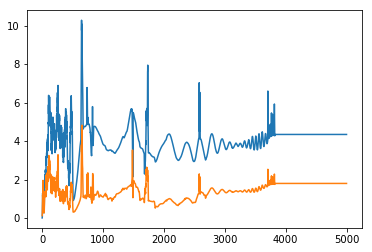

In [13]:
plt.plot(fake_means)
plt.plot(fake_stds)

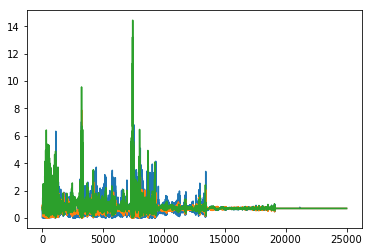

In [14]:
plt.plot(d_real_error)
plt.plot(d_fake_error)
plt.plot(g_fake_error)

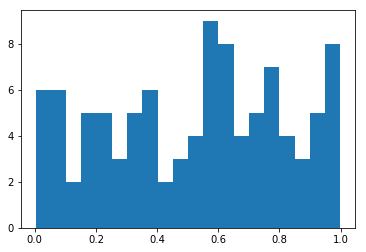

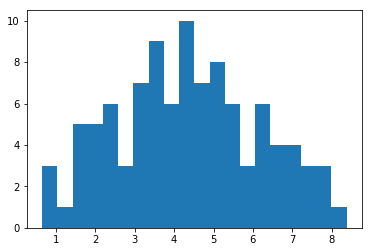

In [15]:
fake_input = Variable(fake_sampler(g_input_size))
plt.hist(fake_input.data.numpy().T, bins=20)
plt.show()

fake_data = G(fake_input)
plt.hist(fake_data.data.numpy().T, bins=20)
plt.show()